In [206]:
## Split HDM4 export for Zambia using mile markers
import pandas as pd
import re
from shapely import ops, wkt
from shapely.geometry import *
import geopandas as gpd
import numpy as np

from pyproj import CRS
GEOD = CRS.from_epsg(4326).get_geod()

In [176]:
def geolen(line):
    return GEOD.geometry_length(line) / 1e3

In [72]:
#%% Read Zambia HDM4 export
hdm4_export = "../data/ZMB/zambia-2017-paved-hdm4.csv"
df = pd.read_csv(hdm4_export)
df

,SECT_NAME,LINK_NAME,LENGTH,ROAD_CLASS,SPEED_FLOW,TRAF_FLOW,ACC_CLASS,CLIM_ZONE,SURF_CLASS,CWAY_WIDTH,...,LAST_CONST,LAST_SURF,LAST_PRVNT,LAST_REHAB,LASTGRAVEL,COMPAGEYEAR,CNSTR_YEAR,COND_YEAR,SECT_ID,LINK_ID
0,D019_04:297530,D019_04:293171-297530,4.359,Tertiary or local,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.1,...,2000,2000,2000,2000,NaN,0,0,2015,D019_04:293171,D019_04
1,D050_01:1520,D050_01:0-1520,1.520,Tertiary or local,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.1,...,2002,2002,2002,2002,NaN,0,0,2015,D050_01:0,D050_01
2,D055_01:2500,D055_01:0-2500,2.500,Tertiary or local,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.1,...,2002,2002,2002,2002,NaN,0,0,2015,D055_01:0,D055_01
3,D055_01:14050,D055_01:11300-14050,2.750,Tertiary or local,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.1,...,2002,2002,2002,2002,NaN,0,0,2015,D055_01:11300,D055_01
4,D055_01:5000,D055_01:2500-5000,2.500,Tertiary or local,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.1,...,2002,2002,2002,2002,NaN,0,0,2015,D055_01:2500,D055_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,T006_03:41880,T006_03:38280-41880,3.600,Primary or trunk,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.7,...,2008,2008,2008,2008,NaN,0,0,2013,T006_03:38280,T006_03
1493,T006_04:44380,T006_04:41880-44380,2.500,Primary or trunk,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.7,...,2008,2008,2008,2008,NaN,0,0,2013,T006_04:41880,T006_04
1494,T006_04:46880,T006_04:44380-46880,2.500,Primary or trunk,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.7,...,2008,2008,2008,2008,NaN,0,0,2013,T006_04:44380,T006_04
1495,T006_04:49880,T006_04:46880-49880,3.000,Primary or trunk,ZMSF2,Free-Flow,ZM ACC CLS,Tropical Arid,0,6.7,...,2008,2008,2008,2008,NaN,0,0,2013,T006_04:46880,T006_04


In [347]:
# %% Parse out road name an mile markers from LINK_NAME
link_rx = '(?P<ROAD_NAME>\w+)_(?P<ROAD_TAG>\d+):(?P<SECT_START>\d+)-(?P<SECT_END>\d+)'
parsed_road_df = df['LINK_NAME'].str.extract(link_rx ,expand=True)
parsed_road_df['LENGTH'] = df.LENGTH
parsed_road_df.insert(0, 'LINK_NAME', df.LINK_NAME)
parsed_road_df.insert(6, 'ROAD_CLASS', df.ROAD_CLASS)
parsed_road_df.insert(7, 'ROUGHNESS', df.ROUGHNESS)
parsed_road_df

,LINK_NAME,ROAD_NAME,ROAD_TAG,SECT_START,SECT_END,LENGTH,ROAD_CLASS,ROUGHNESS
0,D019_04:293171-297530,D019,04,293171,297530,4.359,Tertiary or local,2.24
1,D050_01:0-1520,D050,01,0,1520,1.520,Tertiary or local,4.12
2,D055_01:0-2500,D055,01,0,2500,2.500,Tertiary or local,5.10
3,D055_01:11300-14050,D055,01,11300,14050,2.750,Tertiary or local,4.88
4,D055_01:2500-5000,D055,01,2500,5000,2.500,Tertiary or local,5.50
...,...,...,...,...,...,...,...,...
1492,T006_03:38280-41880,T006,03,38280,41880,3.600,Primary or trunk,3.95
1493,T006_04:41880-44380,T006,04,41880,44380,2.500,Primary or trunk,3.80
1494,T006_04:44380-46880,T006,04,44380,46880,2.500,Primary or trunk,3.47
1495,T006_04:46880-49880,T006,04,46880,49880,3.000,Primary or trunk,3.72


In [90]:
#%% Trim road name (ex: T006 -> T6)
def trim_road_name(s):
    (prefix, number) = re.match(r'(\w+?)(\d+)', s).groups()
    return f'{prefix}{int(number)}'

In [348]:
parsed_road_df['ROAD_NAME'] = \
    parsed_road_df['ROAD_NAME'].apply(trim_road_name)

In [349]:
with pd.option_context('display.max_rows', 500):
    display(parsed_road_df[parsed_road_df.ROAD_NAME == 'D375'].sort_values(['ROAD_NAME', 'ROAD_TAG', 'SECT_START', 'SECT_END']).head(500))

,LINK_NAME,ROAD_NAME,ROAD_TAG,SECT_START,SECT_END,LENGTH,ROAD_CLASS,ROUGHNESS
235,D375_01:0-2600,D375,01,0,2600,2.600,Tertiary or local,6.53
236,D375_01:2600-5100,D375,01,2600,5100,2.500,Tertiary or local,8.34
237,D375_01:5100-7900,D375,01,5100,7900,2.800,Tertiary or local,8.72
238,D375_01:7900-10868,D375,01,7900,10868,2.968,Tertiary or local,7.69
239,D375_02:10868-13368,D375,02,10868,13368,2.500,Tertiary or local,7.96
240,D375_02:13368-15968,D375,02,13368,15968,2.600,Tertiary or local,9.05
241,D375_02:15968-76884,D375,02,15968,76884,60.916,Tertiary or local,7.84


In [7]:
# %% Load OSM roads from Geofrabik extract
osm_roads_shp = "../data/ZMB/zambia-latest-free.shp/gis_osm_roads_free_1.shp"
zmb_roads_gdf = gpd.read_file(osm_roads_shp, layer='gis_osm_roads_free_1')
zmb_roads_gdf

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,10423486,5121,unclassified,Sichango Drive,None,B,0,0,F,F,"LINESTRING (25.85570 -17.87637, 25.85317 -17.8..."
1,10423488,5122,residential,None,None,B,0,0,F,F,"LINESTRING (25.84709 -17.88085, 25.84697 -17.8..."
2,10424051,5112,trunk,None,None,B,0,0,F,F,"LINESTRING (25.28188 -17.76862, 25.27986 -17.7..."
3,21017092,5113,primary,None,M1,B,0,0,F,F,"LINESTRING (31.36650 -8.97807, 31.36653 -8.978..."
4,21486874,5114,secondary,None,None,B,0,0,F,F,"LINESTRING (30.09093 -9.04848, 30.08510 -9.044..."
...,...,...,...,...,...,...,...,...,...,...,...
324857,954732116,5122,residential,None,None,B,0,0,F,F,"LINESTRING (31.05327 -13.19671, 31.05336 -13.1..."
324858,954732117,5122,residential,None,None,B,0,0,F,F,"LINESTRING (31.05349 -13.19710, 31.05356 -13.1..."
324859,954732118,5122,residential,None,None,B,0,0,F,F,"LINESTRING (31.05340 -13.19688, 31.05347 -13.1..."
324860,954732283,5154,path,None,None,B,0,0,F,F,"LINESTRING (31.05305 -13.19715, 31.05312 -13.1..."


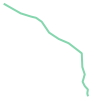

In [135]:
#%% Test Case, Pull out T6
xdf = zmb_roads_gdf[zmb_roads_gdf['ref'].str.upper() == 'D235'].to_crs(epsg=4326)
segments = list(xdf['geometry'])

road_geom = ops.linemerge(segments)
road_geom

In [99]:
len(segments)

13

In [111]:
GEOD.geometry_length(t6) / 1e3, sum([GEOD.geometry_length(s) / 1e3 for s in segments]), parsed_road_df[parsed_road_df.ROAD_NAME == 'T6'].LENGTH.sum()

(55.57623615235627, 55.57623615235628, 34.809999669999996)

In [350]:
road_and_osm_df = parsed_road_df.groupby(['ROAD_NAME']).agg({'LENGTH': 'sum'}).merge(zmb_roads_gdf, how='inner', left_on='ROAD_NAME', right_on='ref')

In [351]:
road_and_osm_df['OSM_LENGTH'] = road_and_osm_df.geometry.map(lambda g: GEOD.geometry_length(g) if g is not None else 0)

In [352]:
road_and_osm_df

,LENGTH,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,OSM_LENGTH
0,58.153999,275768253,5113,primary,None,D100,B,0,0,F,F,"LINESTRING (29.46363 -12.10145, 29.46537 -12.0...",17729.941633
1,58.153999,275768255,5113,primary,None,D100,B,0,0,F,F,"LINESTRING (29.47625 -11.97021, 29.47651 -11.9...",2536.220745
2,1.620000,24723239,5114,secondary,None,D103,B,0,0,F,F,"LINESTRING (33.18034 -12.22538, 33.18041 -12.2...",45526.348065
3,1.620000,24795591,5114,secondary,None,D103,B,0,0,F,F,"LINESTRING (33.29024 -11.37692, 33.29017 -11.3...",6293.241872
4,1.620000,28852761,5113,primary,None,D103,B,0,0,F,F,"LINESTRING (33.17401 -12.29448, 33.17429 -12.2...",1255.685191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,34.810000,659350835,5112,trunk,None,T6,F,0,0,F,F,"LINESTRING (32.04657 -14.05349, 32.04652 -14.0...",28.316117
1566,34.810000,659356601,5112,trunk,None,T6,B,0,1,T,F,"LINESTRING (32.18831 -14.20701, 32.18879 -14.2...",54.895795
1567,34.810000,659356602,5112,trunk,None,T6,B,0,0,F,F,"LINESTRING (32.16996 -14.21329, 32.17068 -14.2...",2105.170937
1568,34.810000,659356865,5112,trunk,None,T6,B,0,1,T,F,"LINESTRING (32.32684 -14.21306, 32.32687 -14.2...",10.975221


In [353]:
road_and_osm_df['trunk'] = road_and_osm_df.fclass == 'trunk'
road_and_osm_df['motorway'] = road_and_osm_df.fclass == 'motorway'
road_and_osm_df['primary'] = road_and_osm_df.fclass == 'primary'
road_and_osm_df['secondary'] = road_and_osm_df.fclass == 'secondary'
road_and_osm_df['tertiary'] = road_and_osm_df.fclass == 'tertiary'
road_and_osm_df['other'] = ~road_and_osm_df.fclass.isin(['trunk', 'motorway', 'primary', 'secondary', 'tertiary'])

In [354]:
# merged_roads = road_and_osm_df.groupby(['ref', 'fclass', 'LENGTH']).agg({'OSM_LENGTH': lambda x: sum(x) / 1e3}).reset_index()
merged_roads = road_and_osm_df.groupby(['ref', 'LENGTH']).agg({
    'OSM_LENGTH': lambda x: sum(x) / 1e3, 
#     'fclass': lambda s: set(s), 
    'trunk': lambda x: 100 * sum(x) / len(x),
    'motorway': lambda x: 100 * sum(x) / len(x),
    'primary': lambda x: 100 * sum(x) / len(x),
    'secondary': lambda x: 100 * sum(x) / len(x),
    'tertiary': lambda x: 100 * sum(x) / len(x),
    'other': lambda x: 100 * sum(x) / len(x),
    'geometry': ops.linemerge,
#     'geometry': lambda x: GEOD.geometry_length(ops.linemerge(x)) / 1e3,
}).reset_index()

merged_roads['diff'] = (merged_roads.LENGTH - merged_roads.OSM_LENGTH).abs()
merged_roads['pct_err'] = 100 * merged_roads['diff'] / merged_roads.LENGTH
merged_roads.sort_values('pct_err')

,ref,LENGTH,OSM_LENGTH,trunk,motorway,primary,secondary,tertiary,other,geometry,diff,pct_err
10,D375,76.884000,76.982269,0.000000,False,0.000000,96.551724,0.000000,3.448276,"LINESTRING (27.47599 -16.43816, 27.47700 -16.4...",0.098269,0.127815
7,D235,175.160000,175.530330,0.000000,False,100.000000,0.000000,0.000000,0.000000,"LINESTRING (29.49627 -11.95884, 29.49688 -11.9...",0.370330,0.211424
26,M4,86.190000,89.273687,0.000000,False,100.000000,0.000000,0.000000,0.000000,"MULTILINESTRING ((28.25768 -12.56085, 28.25763...",3.083687,3.577778
23,M15,63.220000,67.670337,0.000000,False,100.000000,0.000000,0.000000,0.000000,"LINESTRING (28.76905 -16.52522, 28.76853 -16.5...",4.450337,7.039445
30,T1,400.731998,432.934833,100.000000,False,0.000000,0.000000,0.000000,0.000000,"MULTILINESTRING ((25.85936 -17.84442, 25.85925...",32.202835,8.036003
8,D271,123.930000,134.759958,0.000000,False,0.000000,90.909091,0.000000,9.090909,"MULTILINESTRING ((26.40885 -12.11785, 26.40899...",10.829958,8.738771
32,T3,316.151999,366.730049,100.000000,False,0.000000,0.000000,0.000000,0.000000,"MULTILINESTRING ((27.79575 -12.26494, 27.79469...",50.578050,15.998017
29,M9,582.949998,701.335963,60.493827,False,35.802469,1.234568,2.469136,0.000000,"MULTILINESTRING ((23.13380 -15.26963, 23.13351...",118.385965,20.308082
27,M6,41.539000,32.559160,100.000000,False,0.000000,0.000000,0.000000,0.000000,"MULTILINESTRING ((28.46600 -13.04854, 28.46585...",8.979840,21.617853
31,T2,963.543996,1183.945891,53.617021,False,46.382979,0.000000,0.000000,0.000000,"MULTILINESTRING ((28.18225 -15.75638, 28.18220...",220.401895,22.874087


In [387]:
parsed_road_df.groupby('ROAD_NAME').size().reset_index()

,ROAD_NAME,0
0,D100,1
1,D102,1
2,D103,1
3,D104,1
4,D125,2
...,...,...
97,T2,254
98,T3,94
99,T4,87
100,T5,100


In [355]:
len(merged_roads[merged_roads.pct_err <= 25]), len(merged_roads[merged_roads['diff'] <= 20])

(10, 8)

In [380]:
merged_roads[merged_roads.pct_err <= 25].LENGTH.sum(), merged_roads[merged_roads.pct_err <= 25].LENGTH.sum() / merged_roads.LENGTH.sum()

(2830.3009904189985, 0.6013112294613749)

In [374]:
matched_roads = merged_roads[merged_roads.pct_err <= 25]
matched_roads = matched_roads.rename(mapper={'LENGTH': 'FULL_LENGTH', 'OSM_LENGTH': 'FULL_OSM_LENGTH'}, axis='columns')
matched_roads[['ref', 'FULL_LENGTH', 'FULL_OSM_LENGTH', 'diff', 'pct_err']].sort_values('pct_err')

,ref,FULL_LENGTH,FULL_OSM_LENGTH,diff,pct_err
10,D375,76.884000,76.982269,0.098269,0.127815
7,D235,175.160000,175.530330,0.370330,0.211424
26,M4,86.190000,89.273687,3.083687,3.577778
23,M15,63.220000,67.670337,4.450337,7.039445
30,T1,400.731998,432.934833,32.202835,8.036003
8,D271,123.930000,134.759958,10.829958,8.738771
32,T3,316.151999,366.730049,50.578050,15.998017
29,M9,582.949998,701.335963,118.385965,20.308082
27,M6,41.539000,32.559160,8.979840,21.617853
31,T2,963.543996,1183.945891,220.401895,22.874087


In [375]:
matched_roads_w_iri = matched_roads.merge(parsed_road_df[['ROAD_NAME', 'LENGTH', 'ROUGHNESS']], how='left', right_on='ROAD_NAME', left_on='ref')

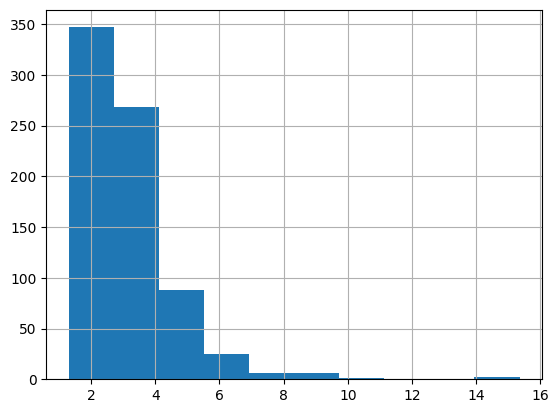

In [376]:
matched_roads_w_iri.ROUGHNESS.hist()
plt.show()

In [378]:
matched_roads_w_iri[matched_roads_w_iri.ROUGHNESS <= 5].LENGTH.sum()

2623.037991819

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

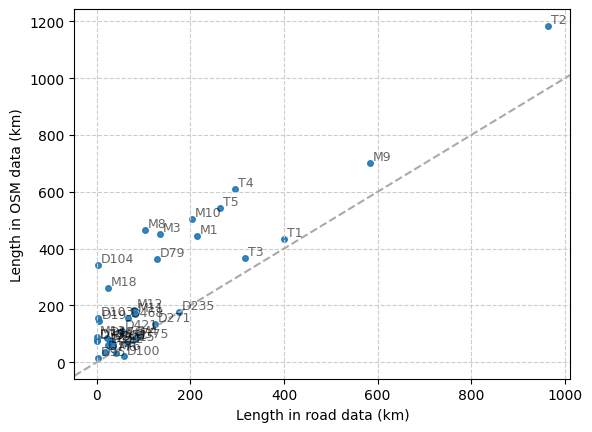

In [336]:
fig = plt.figure()
plt.scatter(merged_roads.LENGTH, merged_roads.OSM_LENGTH, s=16, alpha=0.9, marker='o')
for ref, l1, l2 in zip(merged_roads.ref, merged_roads.LENGTH, merged_roads.OSM_LENGTH):
    plt.annotate(ref, (l1, l2), xytext=(2, 2), textcoords='offset points', fontsize=9, alpha=0.6)
plt.axline((1, 1), slope=1, alpha=1, color='#aaa', linestyle='--')
# plt.axline((0, 20), slope=1, alpha=.5, color='#aaa', linestyle='--')
# plt.axline((0, -20), slope=1, alpha=.5, color='#aaa', linestyle='--')
plt.xlabel('Length in road data (km)')
plt.ylabel('Length in OSM data (km)')
plt.grid(color='#ccc', linestyle='--')
plt.show()

In [337]:
fig.savefig('zambia_lens_scatter.png', bbox_inches='tight', pad_inches=0.2)

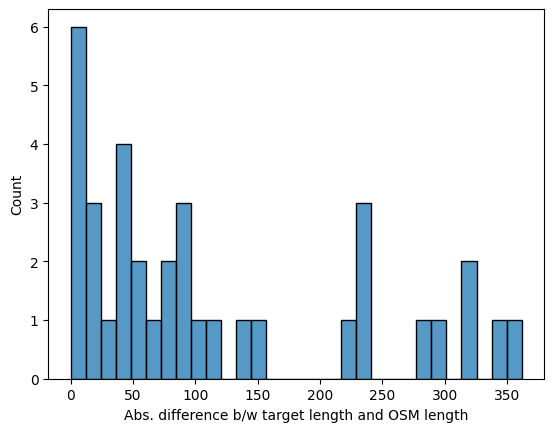

In [52]:
sns.histplot(merged_roads['diff'], bins=30)
plt.xlabel('Abs. difference b/w target length and OSM length')
plt.ylabel('Count')
plt.show()

In [177]:
# https://gis.stackexchange.com/a/316174/181526

from shapely.geometry import Point, LineString

def road_to_segments(road, seg_lengths):
    L_world = geolen(road)
    L_geom = road.length
    seg_lengths = [(l / L_world) * L_geom for l in seg_lengths]
    return line_to_segments(road, seg_lengths)

def line_to_segments(line, seg_lengths):
    if len(seg_lengths) == 0: 
        return []
    if line.length <= seg_lengths[0]:
        return [line]

    head, tail = cut(line, seg_lengths[0])
    return [head] + line_to_segments(tail, seg_lengths[1:])

def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    # https://shapely.readthedocs.io/en/stable/manual.html
    if distance <= 0.0 or distance >= line.length:
        return [line]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p)) 
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

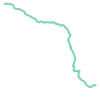

In [189]:
road_name = 'D375'
xdf = zmb_roads_gdf[zmb_roads_gdf['ref'].str.upper() == road_name].to_crs(epsg=4326)
segments = list(xdf['geometry'])
road_geom = ops.linemerge(segments)
road_geom

In [194]:
seg_lens = parsed_road_df[parsed_road_df.ROAD_NAME == road_name].LENGTH
# seg_names = parsed_road_df[parsed_road_df.ROAD_NAME == road_name].LENGTH
len(seg_lens), seg_lens.to_list()

(7, [2.5999999, 2.5, 2.8, 2.9679999, 2.5, 2.5999999, 60.916])

In [191]:
road_segs = road_to_segments(road_geom, seg_lens)
len(road_segs)

7

In [192]:
for seg, l in zip(road_segs, seg_lens):
    print(geolen(seg), l)

2.560146493235468 2.5999999
2.4807239772284597 2.5
2.7956783980878086 2.8
2.936173238927516 2.9679999
2.509164269722953 2.5
2.575527238253567 2.5999999
61.02782644609606 60.916


In [242]:
palette = [
  '#b80058',
  '#006e00',
  '#d163e6',
  '#b24502',
  '#5954d6',
  '#00c6f8',
  '#878500',
  '#00a76c',
  '#bdbdbd',
]

In [246]:
import math

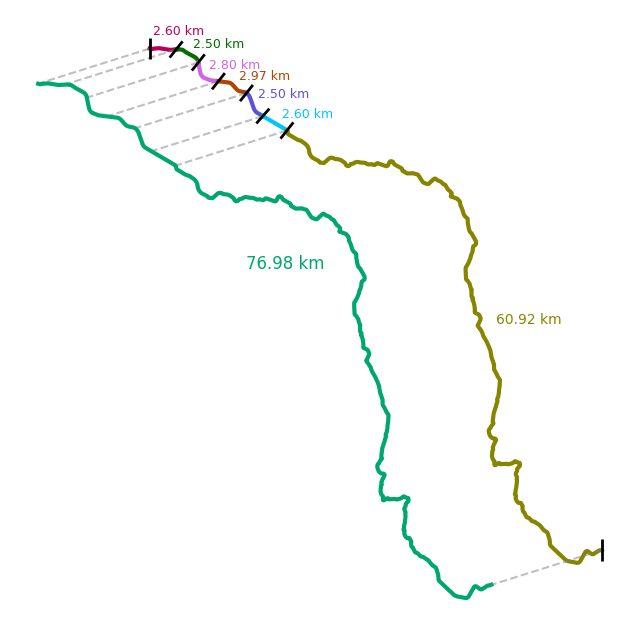

In [324]:
fig = plt.figure(figsize=(8, 8))
ann_params = [
    {'xytext': (-5, 10), 'fontsize': 9},
    {'xytext': (3, 5), 'fontsize': 9},
    {'xytext': (3, 5), 'fontsize': 9},
    {'xytext': (3, 5), 'fontsize': 9},
    {'xytext': (3, 5), 'fontsize': 9},
    {'xytext': (3, 5), 'fontsize': 9},
    {'xytext': (20, 0), 'fontsize': 10},
]
for i, (seg, l, ann_opts) in enumerate(zip(road_segs, seg_lens, ann_params)):
    x, y = seg.xy
    plt.plot(x, y, linewidth=3, color=palette[i])
    if i == 0:
        plt.vlines(x=x[0], ymin=y[0]-.0075, ymax=y[0]+.0075, color='k', linewidth=2, zorder=1000)
    if i < len(road_segs) - 1:
        angle = (math.atan2(y[-1] - y[0], x[-1] - x[0]) + math.pi * .5)
        slope = np.clip(math.tan(angle), a_min=-1, a_max=1)
        dy = slope * 0.005
        plt.plot([x[-1]-0.005, x[-1]+0.005], [y[-1] - dy, y[-1] + dy], color='k', linewidth=2, zorder=1000)
    else:
        plt.vlines(x=x[-1], ymin=y[-1]-.0075, ymax=y[-1]+.0075, color='k', linewidth=2, zorder=1000)
    x_m, y_m = np.mean(x), np.mean(y)
    plt.annotate(f'{l:.2f} km', (x_m, y_m), textcoords='offset points', alpha=1, color=palette[i], **ann_opts)
    if i == 0:
        plt.plot([x[0], x[0] - 0.1], [y[0], y[0] - 0.025], linestyle='--', alpha=0.5, color='gray')
    plt.plot([x[-1], x[-1] - 0.1], [y[-1], y[-1] - 0.025], linestyle='--', alpha=0.5, color='gray')
    
x, y = road_geom.xy
x = np.array(x) - .1
y = np.array(y) - .025
plt.plot(x, y, linewidth=3, color=palette[-2])
plt.annotate(f'{geolen(road_geom):.2f} km', (x_m, y_m), textcoords='offset points', alpha=1, color=palette[-2], **{'xytext': (-160, 40), 'fontsize': 12})

plt.axis('off')
plt.show()

In [325]:
fig.savefig('zambia_road_seg.png', bbox_inches='tight', pad_inches=0.)

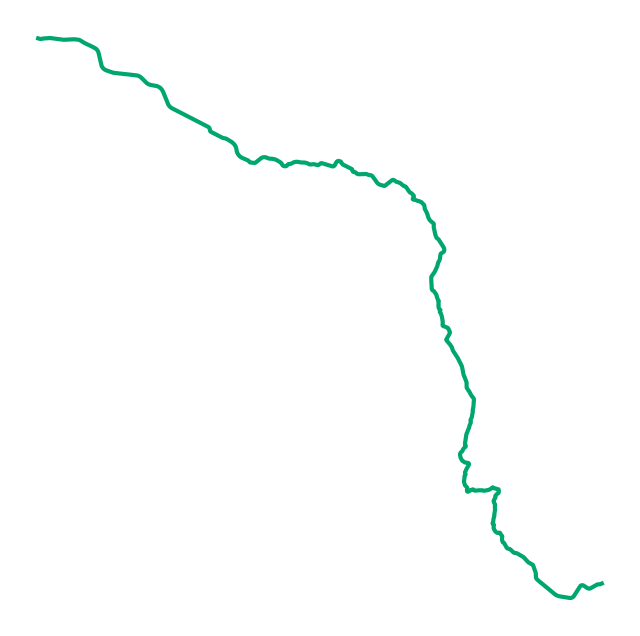

In [302]:
fig = plt.figure(figsize=(8, 8))
x, y = road_geom.xy
x = np.array(x) - .5
plt.plot(x, y, linewidth=3, color=palette[-2])
plt.annotate(f'{geolen(road_geom):.2f} km', (x_m, y_m), textcoords='offset points', alpha=1, color=palette[-2], **{'xytext': (-120, 150), 'fontsize': 14})
plt.axis('off')
plt.show()

In [300]:
fig.savefig('zambia_road_full.png', bbox_inches='tight', pad_inches=0.)